# Symphony
## Quick start PBMCs tutorial

Last updated March 13, 2021

In this example, we will construct a reference from two pbmc datasets (10x 3'v1 and 3'v2), then map a third (5') with Symphony.

In [1]:
#devtools::install_github("immunogenomics/symphony", dep = FALSE, force = TRUE)
library(symphony)

In [2]:
suppressPackageStartupMessages({
    source('libs.R') # imports
    source('utils.R') # useful functions
})

## Get the data
If you would like to follow along, we provide the files `exprs_norm_all.rds` and `meta_data_subtypes.csv` in the `data` directory.

In [3]:
# Read in normalized expression and metadata
exprs_norm = readRDS('data/exprs_norm_all.rds')
metadata = read.csv('data/meta_data_subtypes.csv')

dim(exprs_norm)
dim(metadata)

[1] 33694 20886

[1] 20886     8

In [4]:
#rename the datasets
metadata$donor = recode(metadata$donor, fivePrime = "5'", threepfresh = "3'V2", threepv1 = "3'V1")
rownames(metadata) = metadata$cell_id
head(metadata)

,cell_id,donor,nUMI,nGene,percent_mito,cell_type,res_0.80,cell_subtype
,<fct>,<fct>,<int>,<int>,<dbl>,<fct>,<int>,<fct>
threepfresh_AAACCTGAGCATCATC,threepfresh_AAACCTGAGCATCATC,3'V2,2394,871,0.03842941,bcells,3,bnaive
threepfresh_AAACCTGAGCTAACTC,threepfresh_AAACCTGAGCTAACTC,3'V2,1694,806,0.05726092,mono,5,mono14
threepfresh_AAACCTGAGCTAGTGG,threepfresh_AAACCTGAGCTAGTGG,3'V2,4520,1316,0.01946903,tcells,2,cd4mem
threepfresh_AAACCTGCACATTAGC,threepfresh_AAACCTGCACATTAGC,3'V2,2788,898,0.01398852,tcells,1,cd4naive
threepfresh_AAACCTGCACTGTTAG,threepfresh_AAACCTGCACTGTTAG,3'V2,4667,1526,0.03621170,mono,0,mono14
threepfresh_AAACCTGCATAGTAAG,threepfresh_AAACCTGCATAGTAAG,3'V2,4440,1495,0.03806306,mono,0,mono14


## Subset into reference and query

In [5]:
idx_query = which(metadata$donor == "5'") # use 5' dataset as the query
ref_exp = exprs_norm[, -idx_query]
ref_metadata = metadata[-idx_query, ]
query_exp = exprs_norm[, idx_query]
query_metadata = metadata[idx_query, ]

# Build Symphony Reference

## Option 1: Build from Harmony object (preferred method)
This option consists of more steps than Option 2 but allows your code to be more modular and flexible if you want to do your own preprocessing steps before the Harmony integration step. We recommend this option for most users.

It is important to generate `vargenes_means_sds` (containing variable gene means and standard deviations used to scale the genes) as well as save the loadings for the PCA step. 

In [6]:
# ref_exp is a sparse matrix with the normalized genes x cells matrix
ref_exp[1:5, 1:2]

5 x 2 sparse Matrix of class "dgCMatrix"
             threepfresh_AAACCTGAGCATCATC threepfresh_AAACCTGAGCTAACTC
RP11-34P13.3                            .                            .
FAM138A                                 .                            .
OR4F5                                   .                            .
RP11-34P13.7                            .                            .
RP11-34P13.8                            .                            .

In [7]:
# Select and subset reference expression by variable genes
var_genes = vargenes_vst(ref_exp, topn = 2000)
ref_exp = ref_exp[var_genes, ]

In [8]:
# Calculate and save the mean and standard deviations for each gene
vargenes_means_sds = tibble(symbol = var_genes, mean = Matrix::rowMeans(ref_exp))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(ref_exp, vargenes_means_sds$mean)
        
# Scale data
ref_exp_scaled = singlecellmethods::scaleDataWithStats(ref_exp, vargenes_means_sds$mean, vargenes_means_sds$stddev, 1)

In [9]:
head(vargenes_means_sds)

symbol,mean,stddev
<chr>,<dbl>,<dbl>
RPL39,3.139277,1.695006
LYZ,1.796387,1.907826
S100A9,1.609852,1.849555
S100A8,1.381827,1.777127
HLA-DRA,1.904308,1.708515
CD74,2.555970,1.536484


In [10]:
# Run SVD, save gene loadings (s$u)
set.seed(0)
s = irlba(ref_exp_scaled, nv = 20)
Z_pca_ref = diag(s$d) %*% t(s$v) # [pcs by cells]
loadings = s$u

In [11]:
# Run Harmony
set.seed(0)
ref_harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca_ref),  ## PCA embedding matrix of cells
        meta_data = ref_metadata, ## dataframe with cell labels
        theta = c(2),             ## cluster diversity enforcement
        vars_use = c('donor'),    ## variable to integrate out
        nclust = 100,             ## number of clusters in Harmony model
        max.iter.harmony = 20,
        return_object = TRUE,     ## return the full Harmony model object
        do_pca = FALSE            ## don't recompute PCs
)

Harmony 1/20
Harmony 2/20
Harmony 3/20
Harmony 4/20
Harmony 5/20
Harmony 6/20
Harmony 7/20
Harmony 8/20
Harmony 9/20
Harmony 10/20
Harmony 11/20
Harmony 12/20
Harmony converged after 12 iterations


To run the next function `buildReferenceFromHarmonyObj()`, you need to input the saved gene loadings and vargenes_means_sds.

In [12]:
# Compress Harmony reference into a Symphony reference
reference = symphony::buildReferenceFromHarmonyObj(
                           ref_harmObj,            # output object from HarmonyMatrix()
                           ref_metadata,
                           vargenes_means_sds,     # gene names, means, and std devs for scaling
                           loadings,               # genes x PCs
                           verbose = TRUE,
                           do_umap = TRUE,         # Set to TRUE only when UMAP model was saved for reference
                           save_uwot_path = './testing_uwot_model_1')

Save metadata, vargenes (S), and loadings (U)
Save R, Z_orig, Z_corr, and betas from Harmony object
Calculate final L2 normalized reference centroids (Y_cos)
Calculate reference compression terms (Nr and C)
UMAP
Warning message:
“invalid uid value replaced by that for user 'nobody'”Saved uwot model
Finished nicely.


In [13]:
# Save reference (modify with your desired output path)
saveRDS(reference, './testing_reference1.rds')

Let's take a look at what the reference object contains:

In [14]:
str(reference)

List of 10
 $ meta_data     :'data.frame':	13189 obs. of  8 variables:
  ..$ cell_id     : Factor w/ 20886 levels "fivePrime_AAACCTGAGCGATAGC",..: 7698 7699 7700 7701 7702 7703 7704 7705 7706 7707 ...
  ..$ donor       : Factor w/ 3 levels "5'","3'V2","3'V1": 2 2 2 2 2 2 2 2 2 2 ...
  ..$ nUMI        : int [1:13189] 2394 1694 4520 2788 4667 4440 3224 5205 5493 4419 ...
  ..$ nGene       : int [1:13189] 871 806 1316 898 1526 1495 1253 1433 1632 1134 ...
  ..$ percent_mito: num [1:13189] 0.0384 0.0573 0.0195 0.014 0.0362 ...
  ..$ cell_type   : Factor w/ 7 levels "","bcells","dc",..: 2 5 7 7 5 5 7 7 5 7 ...
  ..$ res_0.80    : int [1:13189] 3 5 2 1 0 0 6 4 0 4 ...
  ..$ cell_subtype: Factor w/ 16 levels "","adc","bmem",..: 4 12 5 6 12 12 7 9 12 9 ...
 $ vargenes      : tibble [2,000 × 3] (S3: tbl_df/tbl/data.frame)
  ..$ symbol: chr [1:2000] "RPL39" "LYZ" "S100A9" "S100A8" ...
  ..$ mean  : Named num [1:2000] 3.14 1.8 1.61 1.38 1.9 ...
  .. ..- attr(*, "names")= chr [1:2000] "RPL39" "LYZ

The harmonized embedding is located in the `Z_corr` slot of the reference object.

In [15]:
dim(reference$Z_corr)
reference$Z_corr[1:5, 1:5]

[1]    20 13189

,threepfresh_AAACCTGAGCATCATC,threepfresh_AAACCTGAGCTAACTC,threepfresh_AAACCTGAGCTAGTGG,threepfresh_AAACCTGCACATTAGC,threepfresh_AAACCTGCACTGTTAG
harmony_1,2.278159,-11.582703707,3.989343,5.13853673,-16.15792982
harmony_2,12.053208,-0.001056832,-2.522270,0.01013777,-0.05519409
harmony_3,-4.574630,2.385295167,3.782308,4.00798748,-0.51578103
harmony_4,2.117618,-0.384793712,3.154445,2.26859676,2.82105177
harmony_5,-1.114013,-1.520285358,1.106114,-0.42382572,-0.09791925


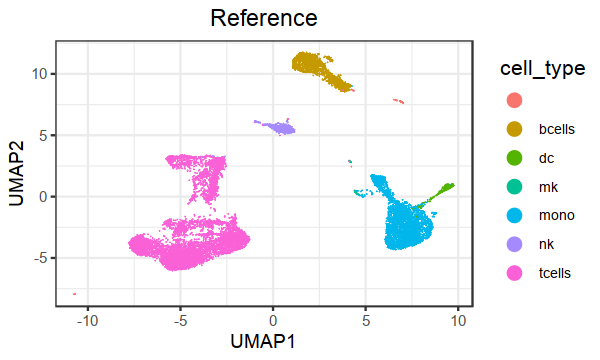

In [16]:
# Visualize reference UMAP
reference = readRDS('./testing_reference1.rds')

umap_labels = cbind(ref_metadata, reference$umap$embedding)

fig.size(3, 5)
plotBasic(umap_labels, title = 'Reference', color.by = 'cell_type')

## Option 2: Build from scratch (starting with expression)

This option computes a reference object starting from expression in a unified pipeline.

In [17]:
# Build reference
set.seed(0)
reference = symphony::buildReference(
    ref_exp,
    ref_metadata,
    vars = c('donor'),       # variables to integrate over
    K = 100,                 # number of Harmony clusters
    verbose = TRUE,
    do_umap = TRUE,          # can set to FALSE if want to run umap separately later
    do_normalize = FALSE,    # set to TRUE if input counts are not normalized yet
    vargenes_method = 'vst', # use vst
    topn = 2000,             # number of variable genes to use
    d = 20,                  # number of PCs
    save_uwot_path = './testing_uwot_model_2'
)

# Save reference (modify with your desired output path)
saveRDS(reference, './testing_reference2.rds')

Finding 2000 variable genes using vst method
Scaling and PCA
Running Harmony integration
Harmony 1/20
Harmony 2/20
Harmony 3/20
Harmony 4/20
Harmony 5/20
Harmony 6/20
Harmony 7/20
Harmony 8/20
Harmony 9/20
Harmony 10/20
Harmony 11/20
Harmony 12/20
Harmony converged after 12 iterations
Running UMAP
Warning message:
“invalid uid value replaced by that for user 'nobody'”Saved uwot model


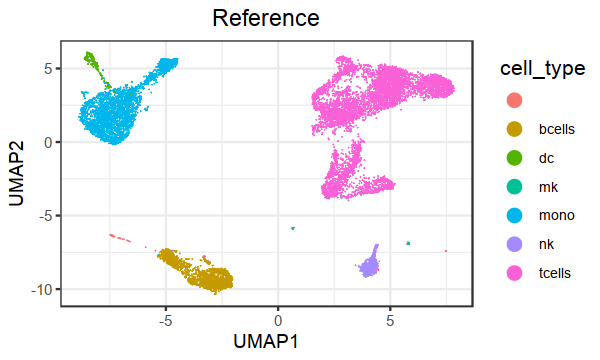

In [18]:
# Visualize reference UMAP
reference = readRDS('./testing_reference2.rds')

umap_labels = cbind(ref_metadata, reference$umap$embedding)

fig.size(3, 5)
plotBasic(umap_labels, title = 'Reference', color.by = 'cell_type')

# Map query

In order to map a new query dataset onto the reference, you will need a reference object saved from the steps above, as well as query cell expression and metadata.

The query dataset is assumed to have been normalized in the same manner as the reference cells (here, default is log(CP10k+1) normalization).

In [19]:
reference = readRDS('./testing_reference1.rds')

In [20]:
# Map query
query = mapQuery(query_exp, 
                 query_metadata, 
                 reference, 
                 do_normalize = FALSE,
                 do_umap = TRUE)

# Predict query cell types using k-NN
query = knnPredict(query, reference, reference$meta_data$cell_type, k = 5)

Scaling and synchronizing query gene expression
Found 2000 reference variable genes in query dataset
Project query cells using reference gene loadings
Clustering query cells to reference centroids
Correcting query batch effects
UMAP
All done!


In [21]:
head(query$meta_data)

,cell_id,donor,nUMI,nGene,percent_mito,cell_type,res_0.80,cell_subtype,cell_type_pred_knn
,<fct>,<fct>,<int>,<int>,<dbl>,<fct>,<int>,<fct>,<fct>
fivePrime_AAACCTGAGCGATAGC,fivePrime_AAACCTGAGCGATAGC,5',2712,1318,0.06637168,nk,9,nk,nk
fivePrime_AAACCTGAGCTAAACA,fivePrime_AAACCTGAGCTAAACA,5',6561,2164,0.05654626,mono,0,mono14,mono
fivePrime_AAACCTGAGGGAGTAA,fivePrime_AAACCTGAGGGAGTAA,5',6322,2112,0.05615312,mono,0,mono14,mono
fivePrime_AAACCTGAGTCTTGCA,fivePrime_AAACCTGAGTCTTGCA,5',4528,1526,0.07199647,tcells,11,cd8eff,tcells
fivePrime_AAACCTGAGTTCGATC,fivePrime_AAACCTGAGTTCGATC,5',3426,1332,0.06830123,mono,0,mono14,mono
fivePrime_AAACCTGCACACTGCG,fivePrime_AAACCTGCACACTGCG,5',6199,1998,0.05097596,bcells,8,bmem,bcells


Query cell type predictions are in the `cell_type_pred_knn` column.

## Visualization of mapping

In [22]:
# Sync the column names for both data frames
reference$meta_data$cell_type_pred_knn = NA

reference$meta_data$ref_query = 'reference'
query$meta_data$ref_query = 'query'

meta_data_combined = rbind(query$meta_data, reference$meta_data)

# Add the UMAP coordinates to the metadata
umap_combined = rbind(query$umap, reference$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

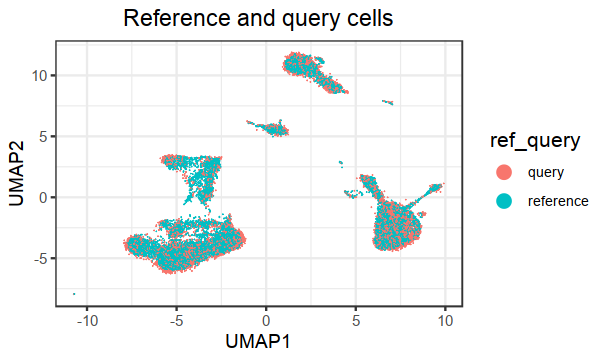

In [23]:
# Plot UMAP visualization
fig.size(3, 5)
plotBasic(umap_combined_labels, title = 'Reference and query cells', color.by = 'ref_query')

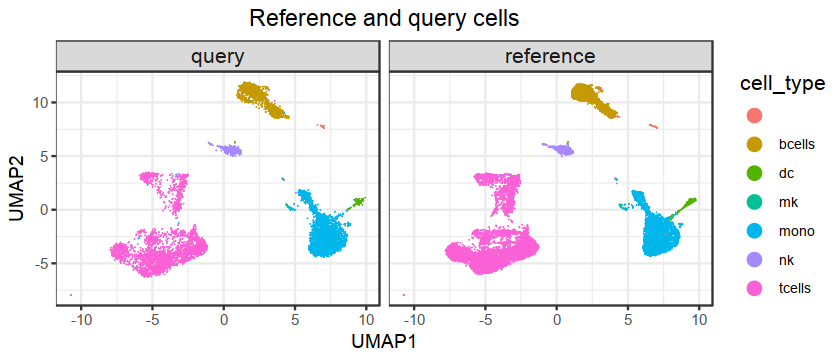

In [24]:
fig.size(3, 7)
plotBasic(umap_combined_labels, title = 'Reference and query cells', 
          color.by = 'cell_type', facet.by = 'ref_query')

And that's a wrap! If you run into issues or have questions about Symphony or this tutorial, please open an issue on GitHub or email joyce_kang@hms.harvard.edu.